In [1]:
import matplotlib.pyplot as plt
import os
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
import numpy as np

plt.style.use('seaborn-colorblind')

def load(directory,runs):
    directory = directory+'/metrics/'
    run = 0
    exit_values = np.load(directory+'exits-run'+"-"+str(run)+".npy")
    mac_readings = np.load(directory+'layerwise_macs.npy')
    
    for run in range(run+1,runs):
        value = np.load(directory+'exits-run'+"-"+str(run)+".npy")
        exit_values = np.vstack((exit_values,value))
    
    return exit_values,mac_readings

def get_label(branch_weights, model = 'B-Rnet ('):
    string = model
    for weight in branch_weights:
        weight = np.round(weight,decimals=3)
        string = string + str(weight) + " : "
    string = string[:-3]+')'
    return(string)

def get_MACs_acc(directory, runs, important, layers):
    model = directory.split('/')[2]
    exits, macs = load(directory,runs)
    layerwise_macs = np.take(macs,important)
    branch_weights = np.load(directory+"/metrics/branch-weights-"+model+".npy")
    label = get_label(branch_weights,model = (model+" ("))
    accuracies = np.load(directory+"/metrics/branch-val-accuracies-"+model+".npy")
    mean_accuracies = np.mean(accuracies,axis=0)
    std_accuracies = np.std(accuracies,axis=0)
    
    accs = np.zeros(4)
    std = np.zeros(4)
    for idx,row in enumerate(mean_accuracies):
        branch_best = np.argmax(row)
        accs[idx] = mean_accuracies[idx,branch_best]
        std[idx] = std_accuracies[idx,branch_best]
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)
    
    return powers, accs, std, label

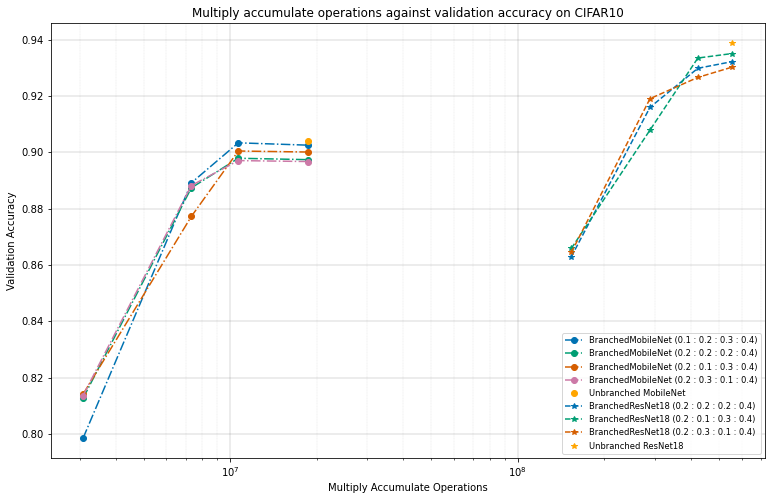

In [6]:
# dataset = 'eurosat-rgb'
dataset = 'CIFAR10'
# dataset = 'sat-6'

simplenet_sat6 = 557875206.0
spectrumnet_dsc = 75.59e6
spectrumnet_standard = 203.47e6
resnet_power_sat6 = 458113542.0
resnet_power_CIFAR = 556651530.0
# resnet_power_eurosat_rgb = 
mobilenet_power_CIFAR = 18582632.0
mobilenet_power_sat6 = 15892068.0
# mobilenet_power_eurosat_rgb = 

directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-lr-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 

mobile_net_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobile_net_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

colours = ['orangered','seagreen', 'darkmagenta', 'orange']

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    powers,accs,std,label = get_MACs_acc(plot_directory, 3, mobile_net_layers, mobile_net_branches)
    plt.plot(powers,accs,'-.o',label=label)#,color = colour)
#     plt.errorbar(powers, accs, yerr=std, fmt='o', color='black',ecolor='lightgray', elinewidth=3, capsize=0);


mobilenet_power = np.sum(powers[3:])
plot_directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-lr-unbranched/"
accs = np.load(plot_directory+"metrics/branch-val-accuracies-BranchedMobileNet.npy")
u_mnet_acc = np.max(np.mean(accs[:,-1,:],axis=0))
plt.plot(mobilenet_power,u_mnet_acc,'o',label='Unbranched MobileNet',color = 'orange')



plt.gca().set_prop_cycle(None)    
directory = "../trained-models/BranchedResNet18/"+dataset+"/CA-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 
names = ["wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 

res_net_layers = [1,2,3,16,31,46,61,62,63,64]
res_net_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    powers,accs,std,label = get_MACs_acc(plot_directory, 3, res_net_layers, res_net_branches)
    plt.plot(powers,accs,'--*',label=label)#,color = colour)
#     plt.errorbar(powers, accs, yerr=std, fmt='o', color='black',ecolor='lightgray', elinewidth=3, capsize=0);
    
resnet_power = np.sum(powers[3:])
plot_directory = "../trained-models/BranchedResNet18/"+dataset+"/CA-unbranched/"
accs = np.load(plot_directory+"metrics/branch-val-accuracies-BranchedResNet18.npy")
u_rnet_acc = np.max(np.mean(accs[:,-1,:],axis=0))
plt.plot(resnet_power,u_rnet_acc,'*',label='Unbranched ResNet18',color = 'orange')

# plt.plot(spectrumnet_dsc,0.876,'v',label='SpectrumNet w/ DSC',color = 'orangered')
# plt.plot(spectrumnet_standard,0.921,'^',label='SpectrumNet',color = 'orangered')

# plt.plot(simplenet_sat6,0.9947,'v',label='Simplenet',color = 'orangered')

#Defining properties of axes
plt.xscale('log')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.title('Multiply accumulate operations against validation accuracy on ' + dataset)
plt.ylabel('Validation Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.legend(fontsize='small',loc=4)

#saveplot
plt.savefig('../trained-models/figures/'+dataset+'-Macs-acc.pdf')

#show plot
plt.show()